# Working with geospatial data in Python  

DataPhilly Workshop
Simon Kassel  
Data Scientist @ [Azavea](https://www.azavea.com/)  

January 21, 2021

### Agenda

1) The basics
 - Vector data
     - [GeoPandas](https://geopandas.org/)
     - [Shapely](https://towardsdatascience.com/geospatial-adventures-step-1-shapely-e911e4f86361)
 - Raster data (imagery)
     - [GDAL](https://gdal.org/)
     - [Rasterio](https://rasterio.readthedocs.io/en/latest/)
 - I/O
 - Windowed reading and writing  

2) Building training data for Machine Learning  
 - Creating chips (smaller images)
 - Rasterizing building labels

### Data
- *__scene.tif__*: an aerial image of a portion of Kampala, Uganda
- *__buildings.geojson__*: building polygons from the same location

In [1]:
%%capture
# rtree and pygeos are required for geopandas.overlay
!pip install rasterio geopandas rtree pygeos

In [2]:
!git clone https://github.com/simonkassel/python-satellite-imagery-workshop.git

fatal: destination path 'python-satellite-imagery-workshop' already exists and is not an empty directory.


In [3]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from rasterio.features import Window
from rasterio.windows import bounds
from shapely.geometry import MultiPolygon, box
from PIL import Image
from rasterio.features import Window
from subprocess import call
from IPython import display

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 1) The basics

### Vector data

How do we store points, lines, and polygons?

![geojson](https://github.com/simonkassel/python-satellite-imagery-workshop/blob/main/img/geojson.png?raw=1)

<br>
<br>

We can work with vector data in python using [GeoPandas](https://geopandas.org/) geodataframes

In [4]:
import os
project_dir = 'python-satellite-imagery-workshop'

In [5]:
!head -n 30 python-satellite-imagery-workshop/buildings.geojson

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:EPSG::32636"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "condition": "good",
                "material": "cement_block"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            459626.5961106891,
                            28121.568562214343
                        ],
                        [
                            459626.8635116092,
                            28133.594468839576
                        ],
                        [
                            459635.69885682187,
                            28134.35689317324


In [6]:
import geopandas as gpd
buildings_dir = os.path.join(project_dir, 'buildings.geojson')
g = gpd.read_file(buildings_dir)
g.head()

,condition,material,geometry
0,good,cement_block,"POLYGON ((459626.596 28121.569, 459626.864 281..."
1,good,concrete,"POLYGON ((459416.838 28816.900, 459436.701 288..."
2,good,cement_block,"POLYGON ((459415.913 28385.227, 459426.062 283..."
3,good,cement_block,"POLYGON ((459402.927 28369.620, 459400.112 283..."
4,good,cement_block,"POLYGON ((459410.038 28399.796, 459413.944 283..."


A geodataframe is pandas dataframe and can do pandas dataframe things, e.g.

In [7]:
g[g['material'] == 'wood']

,condition,material,geometry
138,poor,wood,"POLYGON ((458669.585 28419.038, 458673.613 284..."
377,poor,wood,"POLYGON ((459034.568 28330.392, 459035.592 283..."
393,good,wood,"POLYGON ((459415.538 28874.200, 459414.781 288..."
491,poor,wood,"POLYGON ((459220.965 27876.309, 459224.070 278..."
492,poor,wood,"POLYGON ((459145.186 27872.829, 459148.469 278..."
...,...,...,...
3627,poor,wood,"POLYGON ((459538.011 28175.511, 459534.906 281..."
3628,poor,wood,"POLYGON ((459526.861 28165.198, 459526.705 281..."
3629,poor,wood,"POLYGON ((459521.464 28171.212, 459525.381 281..."
3680,average,wood,"POLYGON ((459089.441 28031.876, 459088.607 280..."


But it also has special methods

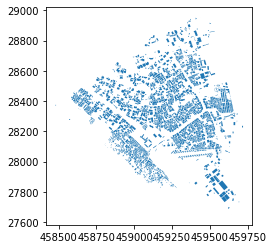

In [8]:
g.plot()

The spatial information (geometries) are stored in the geometry field, which is a pandas series made up of [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) polygons

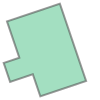

In [9]:
s = g['geometry'].loc[1]
s

In [10]:
print(s)

POLYGON ((459416.8382452434 28816.90015971013, 459436.701219452 28823.55363026951, 459446.5594403809 28794.5165043302, 459429.3671182402 28788.75826767385, 459426.5520730403 28797.04827328593, 459418.0059865348 28794.18573344205, 459415.6026283975 28801.28197817396, 459421.4780628629 28803.24928344227, 459416.8382452434 28816.90015971013))


In [11]:
s.area

664.0568703581537

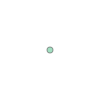

In [12]:
s.centroid

### Raster data (includes images)

Stored as arrays of pixels values that can represent light (i.e. images) or arbitrary values (i.e. land cover classification)  

Examine raster dataset using [GDAL](https://gdal.org/)

In [13]:
!gdalinfo python-satellite-imagery-workshop/img.tif

Driver: GTiff/GeoTIFF
Files: python-satellite-imagery-workshop/img.tif
Size is 6000, 6000
Coordinate System is:
PROJCS["WGS 84 / UTM zone 36N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32636"]]
Origin = (459286.620712036266923,28083.912440528732986)
Pixel Size = (0.035334835417146,-0.035334911276513)
Metadata:
  A

We will read raster files using rasterio and store the values in memory as NumPy arrays

In [14]:
with rasterio.open(os.path.join(project_dir, 'img.tif'), 'r') as src:
    img = src.read()

img

array([[[ 93,  97, 101, ..., 140, 139, 143],
        [100,  95,  91, ..., 163, 162, 166],
        [ 97,  87,  85, ..., 164, 165, 169],
        ...,
        [107, 104, 102, ..., 191, 182, 179],
        [109, 104, 101, ..., 148, 181, 164],
        [ 96,  93,  94, ...,  83, 125, 138]],

       [[ 97,  96,  95, ..., 124, 122, 125],
        [103,  96,  90, ..., 146, 146, 151],
        [ 98,  90,  88, ..., 147, 150, 156],
        ...,
        [122, 119, 117, ..., 180, 173, 173],
        [124, 119, 116, ..., 135, 170, 155],
        [111, 108, 109, ...,  62, 105, 118]],

       [[ 61,  62,  62, ...,  98,  96,  98],
        [ 66,  60,  57, ..., 121, 121, 125],
        [ 61,  54,  54, ..., 124, 126, 131],
        ...,
        [ 57,  54,  52, ..., 164, 167, 161],
        [ 59,  54,  51, ..., 113, 157, 140],
        [ 46,  43,  44, ...,  37,  86,  99]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..

In [15]:
np.max(img)

255

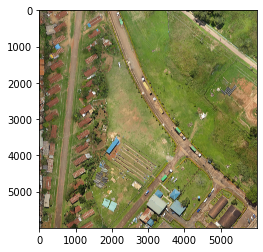

In [16]:
plt.imshow(img.T)

Windowed reading and writing: grab a 1k x 1k pixel image from the very center of this one

In [17]:
with rasterio.open(os.path.join(project_dir, 'img.tif')) as src:
    witdth = src.width
    hight = src.height
    p = src.profile.copy()

In [18]:
col_off = (src.width / 2) - (1000 / 2)
row_off = (src.height / 2) - (1000 / 2)

In [19]:
pprint(p['transform'])

Affine(0.03533483541714589, 0.0, 459286.62071203627,
       0.0, -0.035334911276512705, 28083.912440528733)


In [20]:
win = Window(col_off=col_off, row_off=row_off, width=1000, height=1000)

In [21]:
x = rasterio.open(os.path.join(project_dir, 'img.tif')).window_transform(win)

In [22]:
x

Affine(0.03533483541714589, 0.0, 459374.95780057914,
       0.0, -0.035334911276512705, 27995.575162337453)

In [23]:
with rasterio.open(os.path.join(project_dir, 'img.tif')) as src:
    f = src.read(window=win)
    p = src.profile.copy()
    p['width'] = win.width
    p['height'] = win.height
    p['transform'] = src.window_transform(win)

In [24]:
f.shape

(4, 1000, 1000)

In [25]:
with rasterio.open(os.path.join(project_dir, 'sample.tif'), 'w', **p) as dst:
    dst.write(f)

In [26]:
!ls python-satellite-imagery-workshop

build					img.tif
buildings.geojson			Python_satellite_imagery_workshop.ipynb
colab_satellite_imagery_workshop.ipynb	README.md
DataPhilly-workshop-intro-slides.pdf	requirements.txt
docker-compose.yml			run
Dockerfile				sample.tif
img


## 2) Building training data for Machine Learning  

Prep data for building chip classification

In [27]:
all_bldgs = gpd.read_file(os.path.join(project_dir, 'buildings.geojson'))

In [28]:
with rasterio.open(os.path.join(project_dir, 'img.tif')) as src:
    img_bounds = src.bounds

In [29]:
img_bounds

BoundingBox(left=459286.62071203627, bottom=27871.902972869655, right=459498.6297245391, top=28083.912440528733)

In [30]:
# left, bottom, right, top
l, b, r, t = img_bounds

In [31]:
from shapely.geometry import Polygon

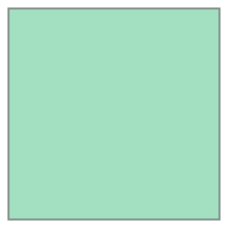

In [32]:
img_bbox = Polygon([(l, b), (l, t), (r, t), (r, b)])
img_bbox

In [33]:
bbox_gdf = gpd.GeoDataFrame({'geometry': [img_bbox]}, crs = 32636)

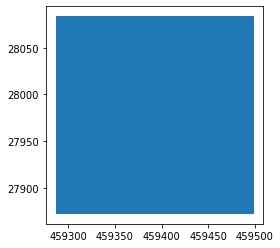

In [34]:
bbox_gdf.plot()

In [35]:
all_bldgs

,condition,material,geometry
0,good,cement_block,"POLYGON ((459626.596 28121.569, 459626.864 281..."
1,good,concrete,"POLYGON ((459416.838 28816.900, 459436.701 288..."
2,good,cement_block,"POLYGON ((459415.913 28385.227, 459426.062 283..."
3,good,cement_block,"POLYGON ((459402.927 28369.620, 459400.112 283..."
4,good,cement_block,"POLYGON ((459410.038 28399.796, 459413.944 283..."
...,...,...,...
3924,poor,brick,"POLYGON ((459145.088 27926.680, 459146.067 279..."
3925,poor,metal;wood,"POLYGON ((459021.426 27916.217, 459024.475 279..."
3926,average,brick,"POLYGON ((459066.106 28001.690, 459067.697 280..."
3927,poor,brick,"POLYGON ((459019.915 27994.109, 459021.740 279..."


In [36]:
bldgs = gpd.overlay(all_bldgs, bbox_gdf, how='intersection')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
import os
from shutil import rmtree
buildings_dir = os.path.join(project_dir, 'buildings')

if os.path.isdir(buildings_dir):
    rmtree(buildings_dir)
os.makedirs(os.path.join(buildings_dir, 'true'))
os.makedirs(os.path.join(buildings_dir, 'false'))

In [38]:
mp = MultiPolygon(bldgs['geometry'].values)

In [39]:
# specify the png image size (in pixels) 
png_size = 600

In [40]:
with rasterio.open(os.path.join(project_dir, 'img.tif')) as src:
    
    # gather width and height of input image
    width = src.width
    height = src.height
    
    # iterate over the image in a grid of 1200x1200 pixel squares
    for w in range(0, width, png_size):
        for h in range(0, height, png_size):

            # construct Window object using row/col and size
            win = Window(w, h, png_size, png_size)
            
            # find the corresponding spatial coordinates
            trans = src.window_transform(win)
            
            # read the window portion in as a numpy array
            a = src.read(window=win)
            
            # create shapely object that represents the bounds of the window
            p = src.profile.copy()
            p['width'] = win.width
            p['height'] = win.height
            p['transform'] = src.window_transform(win)
            with rasterio.open('/tmp/tmp.tif', 'w', **p) as dst:
                bnds = dst.bounds
            
            x = Polygon(box(*bnds))
            
            # check whether the window intersects with any buildings
            has_bldg = x.intersects(mp)
            
            if has_bldg is True:
                label = 'true'
            else:
                label = 'false'
                        
            # create a PIL image from the numpy array
            im = Image.fromarray(a[0:3].T)
            
            # save the image off as a png
            fp = f'{project_dir}/buildings/{label}/{w}-{h}.png'
            im.save(fp)

Example png without a building

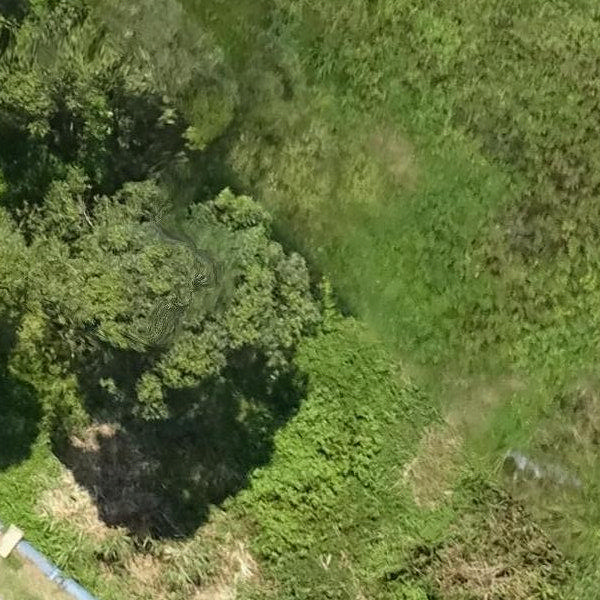

In [41]:
display.Image(filename=f'{buildings_dir}/false/{os.listdir(f"{buildings_dir}/false")[1]}')

Example png with a building

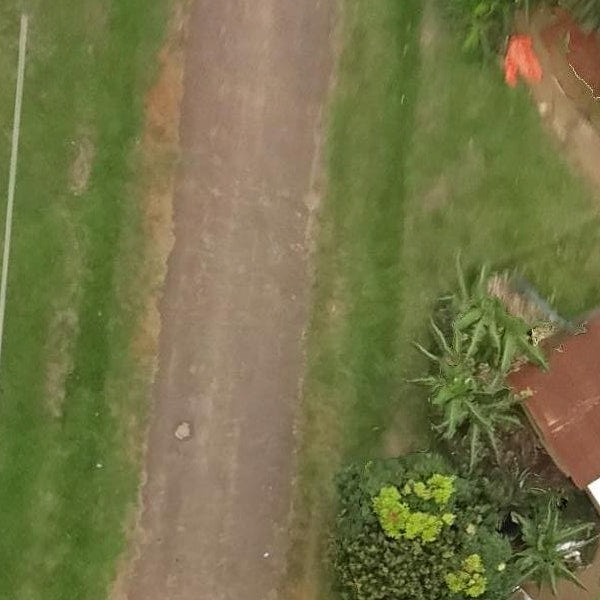

In [42]:
display.Image(filename=f'{buildings_dir}/true/{os.listdir(f"{buildings_dir}/true")[1]}')

Rasterizing polygons

In [43]:
# get a shapely polygon of a window's bounding box
def window_bbox(dataset_reader, win):
    p = dataset_reader.profile.copy()
    p['width'] = win.width
    p['height'] = win.height
    p['transform'] = dataset_reader.window_transform(win)
    with rasterio.open('/tmp/tmp.tif', 'w', **p) as dst:
        bnds = dst.bounds
            
    x = Polygon(box(*bnds))
    
    return x

In [44]:
with rasterio.open(os.path.join(project_dir, 'img.tif'), 'r') as src:
    win = Window(0, 0, 1000, 1000)
    a = src.read(window = win)
    win_bbox = window_bbox(src, win)
    trans = src.window_transform(win)

We need the extent of the polygons we are rasterizing to match up with the extent of the image (or rather portion of an image) that it is paired with, so we will clip the buildings to that extent.  
   

In [45]:
win_bldgs = gpd.clip(bldgs, win_bbox)

Assign a numeric value to the 'condition' variable that we will want to burn into the resulting raster 

In [46]:
win_bldgs['condition_num'] = win_bldgs['condition'].apply(lambda x: 1 if x == 'poor' else 2)

In [47]:
win_bldgs

,condition,material,geometry,condition_num
24,good,brick,"POLYGON ((459304.205 28068.810, 459308.734 280...",2
28,good,brick,"POLYGON ((459291.139 28083.912, 459300.622 280...",2
33,good,brick,"POLYGON ((459321.108 28068.323, 459314.509 280...",2
41,good,brick,"POLYGON ((459286.621 28074.388, 459288.927 280...",2
57,good,brick,"POLYGON ((459320.952 28063.437, 459319.328 280...",2
59,good,brick,"POLYGON ((459286.621 28058.518, 459292.321 280...",2
68,poor,wood,"POLYGON ((459301.713 28071.529, 459301.067 280...",1


Now it's time to rasterize these features

In [48]:
from rasterio.features import rasterize

![rasterize](https://github.com/simonkassel/python-satellite-imagery-workshop/blob/main/img/rasterize.png?raw=1)

Pair each geometry with its appropriate output pixel value

In [49]:
def tuple_to_list(t):
    return list(map(tuple_to_list, t)) if isinstance(t, (list, tuple)) else t

In [50]:
def preformat_geom(geom):
    gj = geom.__geo_interface__
    gj['coordinates'] = tuple_to_list(gj['coordinates'])
    
    return gj

In [51]:
shapes = list(zip(win_bldgs['geometry'], win_bldgs['condition_num']))

In [52]:
shapes

[(<shapely.geometry.polygon.Polygon at 0x7f3817b19390>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19bd0>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19150>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19fd0>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19d90>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19e10>, 2),
 (<shapely.geometry.polygon.Polygon at 0x7f3817b19cd0>, 1)]

The output shape must match the image, but will be only one band

In [53]:
a.shape

(4, 1000, 1000)

In [54]:
out_shape = (1000, 1000)

All values that are not in a building will be given a value of 0

In [55]:
fill = 0

Make sure we include geospatial information

In [56]:
transform = trans

Make sure data type matches image data type

In [57]:
dtype = a.dtype
dtype

dtype('uint8')

In [58]:
pixel_labs = rasterize(shapes=shapes, out_shape=out_shape, fill=fill, transform = transform, dtype = dtype)

In [59]:
pixel_labs.shape

(1000, 1000)

In [60]:
# an example of the middle of the raster layer
pixel_labs[400:600, 400:600]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)

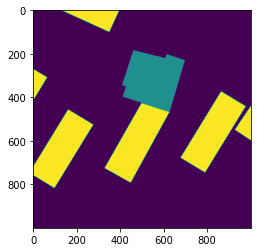

In [61]:
plt.imshow(pixel_labs)

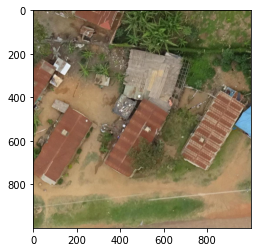

In [62]:
plt.imshow(a[0:3].transpose([1, 2, 0]))

An alternate approach with GDAL

In [63]:
win_bldgs.to_file(os.path.join(project_dir, 'rasterize-bldgs.geojson'), driver='GeoJSON')

`gdal_rasterize` is a command line tool

```
Usage: gdal_rasterize [-b band]* [-i] [-at]
       {[-burn value]* | [-a attribute_name] | [-3d]} [-add]
       [-l layername]* [-where expression] [-sql select_statement]
       [-dialect dialect] [-of format] [-a_srs srs_def] [-to "NAME=VALUE"]*
       [-co "NAME=VALUE"]* [-a_nodata value] [-init value]*
       [-te xmin ymin xmax ymax] [-tr xres yres] [-tap] [-ts width height]
       [-ot {Byte/Int16/UInt16/UInt32/Int32/Float32/Float64/
             CInt16/CInt32/CFloat32/CFloat64}] [-optim {[AUTO]/VECTOR/RASTER}] [-q]
       <src_datasource> <dst_filename>
```

In [64]:
!gdal_rasterize -a condition_num -a_srs EPSG:32636 -ts 1000 1000 python-satellite-imagery-workshop/rasterize-bldgs.geojson python-satellite-imagery-workshop/bldg-raster.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [65]:
with rasterio.open(os.path.join(project_dir, 'bldg-raster.tif'), 'r') as src:
    a = src.read()

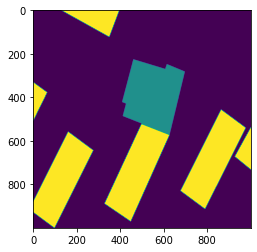

In [66]:
plt.imshow(a[0])